# **Deep Learning Project - Pothole detection** <br/>
# **Transfer Learning**
**Data Science and Advanced Analytics with a specialization in Data Science**<br/>
**NOVA IMS**<br/>
Authors of this notebook:
*   Mafalda Paço - 20220619@novaims.unl.pt
*   Mª Margarida Graça - 20220602@novaims.unl.pt
*   Marta Dinis - 20220611@novaims.unl.pt
*   Nuno Dias - 20220603@novaims.unl.pt
*   Patrícia Morais - 20220638@novaims.unl.pt


## References
1.  https://learnopencv.com/fine-tuning-pre-trained-models-tensorflow-keras/
2. https://datagen.tech/guides/computer-vision/vgg16/

## Ready to use Dataset
https://drive.google.com/file/d/1KE507iE7Hwb7TiJINnvMYCXNIGrEgPvt/view?usp=share_link

## **Summary**
In this notebook, we will apply transfer learning in our dataset.
We used the VGG16 model as a baseline and freezed the initial layers and allowed the last few layers to train according to our dataset.

## **Data Import**

Necessary library imports.

In [ ]:
!pip install -q -U keras-tuner

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import time
import shutil
import zipfile

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Model, layers, initializers, regularizers, optimizers, metrics

from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 3.6 MB/s eta 0:00:00


Connection to the Data Source.

In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/DL/Project/"
main_folder, training_folder, testing_folder = "DATA/", "train/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'DATA.zip', 'DATA.zip')
    # Extract files
    zip_ = zipfile.ZipFile('DATA.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Mounted at /content/drive
File transfer completed in 3.783 seconds


Definition of a list of parameters for the  function `image_dataset_from_directory`. We defined the size to which all images will be resized as well as the the number of batches at a time that our model will be trained on. All of these parameters were adapted accordingly to our problem's complexity.

In [ ]:
image_size=(128, 128) # Experimetar
crop_to_aspect_ratio=True # Experimentar
color_mode='rgb'
batch_size=64
label_mode="binary"
validation_split=0.2
shuffle=True
seed=0

Loads the training data using the function `image_dataset_from_directory` and does an automatic split between training and validation data via validation_split, saving 20% for Validation.

In [ ]:
# Generate an object of type tf.data.Dataset
ds_train, ds_val = image_dataset_from_directory(path + main_folder + training_folder,
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split,
                                                shuffle=shuffle,
                                                seed=seed)

Found 1436 files belonging to 2 classes.
Using 1149 files for training.
Using 287 files for validation.


Loads the testing data using the function `image_dataset_from_directory`.

In [ ]:
ds_test = image_dataset_from_directory(path + main_folder + testing_folder,
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,
                                       shuffle=shuffle,
                                       seed=seed)

Found 16 files belonging to 2 classes.


## **Functions**

#### Plot function

In [ ]:
def plot_result_curves(fit_history, model_name):
  df_hist = pd.DataFrame.from_dict(fit_history.history)
  df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

  secondary_y = ["accuracy", "val_accuracy"]
  ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy",
                  xlabel="Epoch", title="Learning curves"+ " - " + model_name,
                  style=[".--", ".-"]*3,
                  color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"],
                         alpha=0.75, fontsize=10)
  ax.right_ax.set_ylabel("Accuracy")
  ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
  ax.right_ax.set_ylim(0.45, 1.05)
  ax.legend(loc=(1.15, 0.40), framealpha=1.0)
  plt.show()

## **Transfer Learning**

We will now explain, in more detail, what is transfer learning. Transfer LEarning is a Deep Learning technique that reporposes a pre-trained model to make predictions on a new dataset. Basic transfer learning works by 'freezing' the layers of the pre-trained model and therefore keeping its weights unchanged during the training process. Theoretically, the pre-trained model wil be strong enough to detect many different features and is also general enough that we only need to retrain the classifier portion of the network. This way we can improve the accuracy of a model on our dataset by allowing it to learn from a larger and more diverse set of images.

## **FineTuning**

In this attempt we used an alternative to tranfer learning that only freezes the first few layers of the network and allows the last one to be further trained, using our dataset. This is called fine-tuning.
The theory behind this technique indicates that the feature extractor's first layers represents general, low level characteristics, such as edges and corners, that are essential building bloks to many classification tasks. On the other hand, the next layers learn more complex features that are closely related to our particular dataset.

## **VGG 16**

VGG 16 is a convolutional neural network model with 16 layers that, while very extensive, it also has a very simple architecture. Of those 16 layers, three are fully connected layers and 13 convolutional layers and it uses the ReLu activation function.

The outline of the VGG16 model is as follows:


<center><img src="https://datagen.kinsta.cloud/app/uploads/2022/11/image2-1.png" width=600></center>

We started by initiantizing the VGG16 convolutional neural network.The model is pre-trained with the weights from the ImageNet dataset and is trained for 1000 output classes.

 We set the include_top parameter as  making the model run without the final classifier layer.

In [ ]:
tf.keras.applications.vgg16.VGG16(include_top=True,
                                  weights='imagenet',
                                  input_tensor=None,
                                  input_shape=None,
                                  pooling=None,
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )

553467096/553467096 [==============================] - 19s 0us/step


Instance of the VGG16 model. The convolutional base model of VGG16's information, the shape of the output and the number of parameters in each layer as well as the total number of parameters in the model, is printed.

In [ ]:
input_shape = (*image_size, 3)

print('Loading model with ImageNet weights...')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, # We will supply our own top.
                                                    weights='imagenet',
                                                   )
print(vgg16_conv_base.summary())

Loading model with ImageNet weights...
58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                       

To maintain the pre-trained weights and prevent overfitting, the code freezes the initial layers of the convolutional base by setting their trainable attribute to False. Following this, the model was graphically depicted.

In [ ]:
# Set all layers in the convolutional base to Trainable (will FREEZE initial layers further below).
vgg16_conv_base.trainable = True

# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = 8
num_layers = len(vgg16_conv_base.layers)

# Freeze the initial layers in the convolutional base.
for model_layer in vgg16_conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

print("\n")
print(f"Configured to fine tune the last", num_layers_fine_tune, "convolutional layers...")
print("\n")

print(vgg16_conv_base.summary())

FREEZING LAYER: <keras.engine.input_layer.InputLayer object at 0x7fce1c1ada60>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7fce1c289a90>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7fcea47192b0>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fce1c1b77c0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7fce1c1b70a0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7fce1c1b3730>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fce1c1c3bb0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7fce1c1c3670>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7fce1c1b74c0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7fce1c22ff10>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fce1c23ca00>


Configured to fine tune the last 8 convolutional layers...

The input data was preprocessed with the VGG16 preprocessing function and then passed through the convolutional base to obtain a feature map that is flattened into a 1D tensor. Then, a dense layer with ReLU activation function and dropout regularization was applied. Finally an additional dense layer was added with softmax activation function. The model architecture is defined and a summary of the architecture is printed.

In [ ]:
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.applications.vgg16.preprocess_input(inputs)

x = vgg16_conv_base(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# The final `Dense` layer with the number of classes.
outputs = layers.Dense(2, activation='softmax')(x)

# The final model.
model_vgg16_finetune = tf.keras.Model(inputs, outputs)

print(model_vgg16_finetune.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                             

Visualization of the model's architecture.

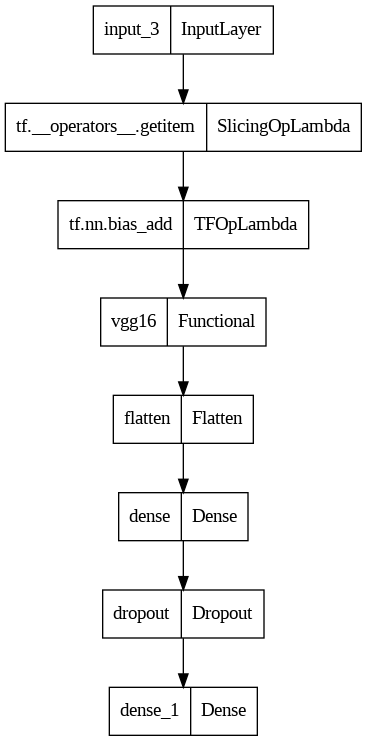

In [ ]:
plot_model(model_vgg16_finetune, to_file='vgg16.png')

The model is then compiled and fitted to our data.

In [ ]:
# Use this for integer encoded labels.
model_vgg16_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )


In [ ]:
# Train the Model.
training_results = model_vgg16_finetune.fit(ds_train,
                                            epochs=30,
                                            validation_data=ds_val
                                           )


Epoch 1/30
18/18 [==============================] - 34s 769ms/step - loss: 1.1333 - accuracy: 0.7850 - val_loss: 0.1528 - val_accuracy: 0.9338
Epoch 2/30
18/18 [==============================] - 8s 324ms/step - loss: 0.1298 - accuracy: 0.9547 - val_loss: 0.0981 - val_accuracy: 0.9582
Epoch 3/30
18/18 [==============================] - 10s 320ms/step - loss: 0.0671 - accuracy: 0.9730 - val_loss: 0.0870 - val_accuracy: 0.9686
Epoch 4/30
18/18 [==============================] - 9s 393ms/step - loss: 0.0537 - accuracy: 0.9765 - val_loss: 0.0725 - val_accuracy: 0.9721
Epoch 5/30
18/18 [==============================] - 8s 317ms/step - loss: 0.0091 - accuracy: 0.9983 - val_loss: 0.1171 - val_accuracy: 0.9617
Epoch 6/30
18/18 [==============================] - 10s 329ms/step - loss: 0.0064 - accuracy: 0.9991 - val_loss: 0.0972 - val_accuracy: 0.9686
Epoch 7/30
18/18 [==============================] - 10s 441ms/step - loss: 0.0078 - accuracy: 0.9983 - val_loss: 0.1019 - val_accuracy: 0.9756
Ep

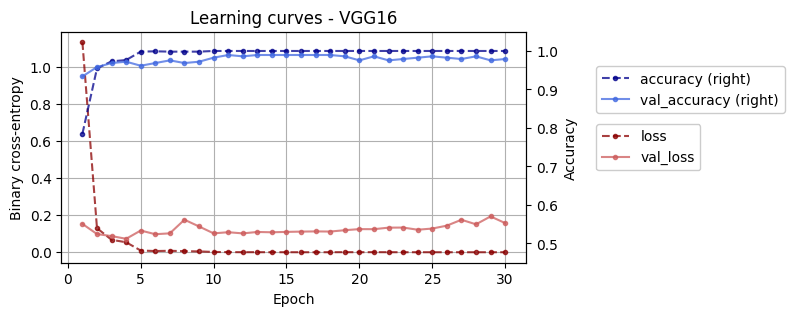

In [ ]:
plot_result_curves(training_results,"VGG16")

With this model we were able to get a much better accuracy even though with a little bit of overfitting. The loss curve is not very 'good' since it suddenly drops indicatinng that the model is not learning anymore.

Now we used the trained model we created to predict the test images and printed each one with the respective class (since our test data is very small we printed every image).

1/1 [==============================] - 0s 48ms/step


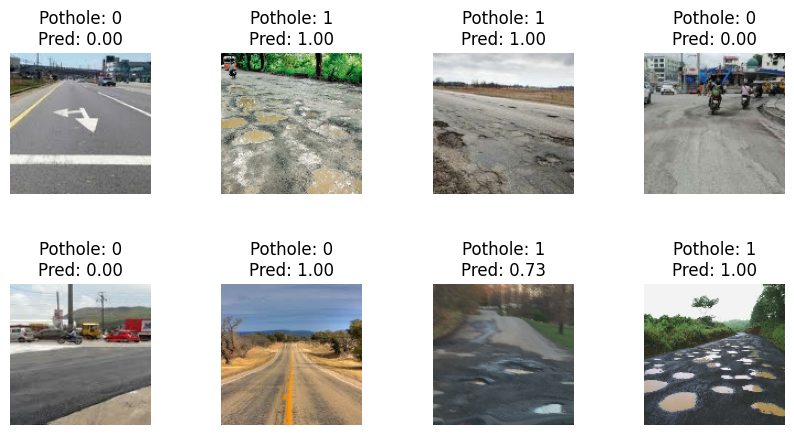

In [ ]:
# Use the trained model to predict on the test data
test_predictions = model_vgg16_finetune.predict(ds_test)

# Print some test images with their respective predictions
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(10, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, (image, label) in enumerate(ds_test.unbatch().take(8)):
    row, col = divmod(i, 4)
    axs[row][col].imshow(image.numpy().astype("uint8"))
    axs[row][col].set_title("Pothole: {}\nPred: {:.2f}".format(int(label.numpy()), test_predictions[i][0]))
    axs[row][col].axis("off")

plt.show()